In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from pyspark.sql import SparkSession
from pyspark.sql.functions import asc, lit

##### Testing for 1 Flight Trip

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Rogue Generator") \
    .getOrCreate()

flights_file_path = os.path.join('dataset', 'raw', '0d02a8', '0d02a8_0.parquet')

read_one_flight = spark.read.parquet(flights_file_path, header=True)

23/10/04 11:18:29 WARN Utils: Your hostname, Barathwajas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.26.40.137 instead (on interface en0)
23/10/04 11:18:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/04 11:18:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def get_values_from_selected_columns(flight_data):
    default_signature_label = 0

    selected_cols = flight_data.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                     'geoaltitude', 'lastposupdate', 'lastcontact' , 'velocity', 'dropout_length') \
                        .orderBy(asc('time'))
    
    selected_cols = selected_cols.withColumn("signature", lit(default_signature_label)) # Adding new column for capturing anomaly signature

    return selected_cols

In [4]:
one_flight = get_values_from_selected_columns(read_one_flight)

In [5]:
one_flight.show(3)

+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|      time|icao24|              lat|               lon|           heading|      baroaltitude|       geoaltitude|   lastposupdate|     lastcontact|          velocity|dropout_length|signature|
+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|1645229867|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|          null|        0|
|1645229868|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|           0.0|        0|
|1645229869|0d02a8|30.18530894134004|-95

In [6]:
def convert_to_pandas(get_flights):
    return get_flights.toPandas()

In [7]:
one_flight_df = convert_to_pandas(one_flight)

In [8]:
one_flight_df.head(3)

,time,icao24,lat,lon,heading,baroaltitude,geoaltitude,lastposupdate,lastcontact,velocity,dropout_length,signature
0,1645229867,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,NaN,0
1,1645229868,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,0.0,0
2,1645229869,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,0.0,0


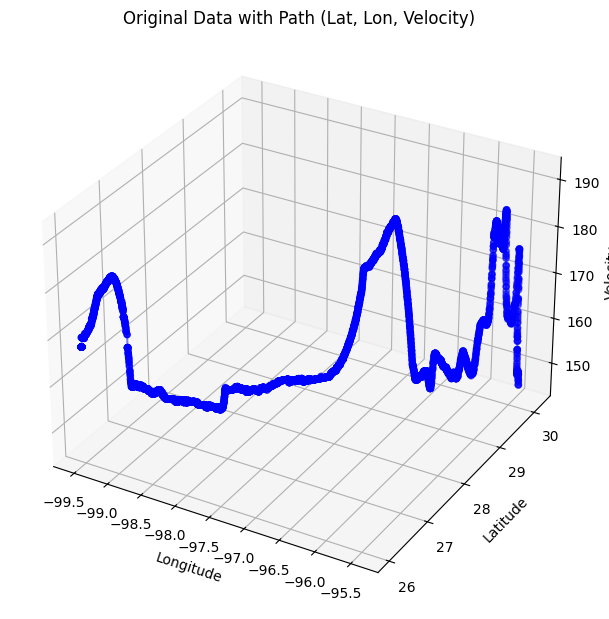

In [9]:
# Create 3D plots for original data paths
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')

# Plot original data with path
ax1.scatter(one_flight_df['lon'], one_flight_df['lat'], one_flight_df['velocity'], c='blue', label='Original Data')
ax1.plot(one_flight_df['lon'], one_flight_df['lat'], one_flight_df['velocity'], c='blue', alpha=0.5, label='Path')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('Velocity')
ax1.set_title('Original Data with Path (Lat, Lon, Velocity)')

plt.tight_layout()
plt.show()

##### Introducing Noise using Akima Interpolation

##### a. One Parameter Alone

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import Akima1DInterpolator


# timestamps = np.copy(one_flight_df['time'])      # epochs timestamp
# latitudes = np.copy(one_flight_df['lat'])        # deg
# longitudes = np.copy(one_flight_df['lon'])       # deg
# velocity = np.copy(one_flight_df['velocity'])    # meters/sec
# signature_label = np.copy(one_flight_df['signature'])

# num_points = 1000
# noise_level = 100


# start_time = timestamps[0]
# end_time = timestamps[-1]

# random_indices = np.random.choice(len(timestamps), num_points, replace=False)

# while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
#     random_indices = np.random.uniform(start_time, end_time, num_points)

# for i in random_indices:
#     latitudes[i] += np.random.uniform(-noise_level, noise_level)
#     longitudes[i] += np.random.uniform(-noise_level, noise_level)
#     velocity[i] += np.random.uniform(-noise_level, noise_level)
#     signature_label[i] = 1

# # Plot the original velocity, interpolated velocity, and noisy velocity
# plt.figure(figsize=(10, 6))
# plt.plot(one_flight_df['time'], one_flight_df['velocity'], 'o', label='Original Velocity', markersize=2)
# # plt.plot(one_flight_df['time'], one_flight_df['velocity'], label='Interpolated Velocity', linestyle='--')
# plt.plot(timestamps, velocity, label='Noisy Velocity', linestyle='-.')
# plt.legend()
# plt.title('Flight Velocity of Original v/s Noise')
# plt.xlabel('Time (epoch timestamp)')
# plt.ylabel('Velocity (metres/sec)')
# plt.grid(True)
# plt.show()

#### Calculate the mean difference

In [11]:
flight_info = [
    # {
    #     'flight_icao24': 'a14af7',
    #     'trip_number': 0
    # },
    # {
    #     'flight_icao24': 'a14af7',
    #     'trip_number': 1
    # },
    {
        'flight_icao24': 'ac3aeb',
        'trip_number': 0
    },
    # {
    #     'flight_icao24': 'ac3aeb',
    #     'trip_number': 1
    # },
]

In [12]:
from pyspark.sql.functions import col, from_unixtime, to_date, date_add, when, monotonically_increasing_id

master_data = []

for value in flight_info:
    flights_file_path = os.path.join('dataset', 'raw', value["flight_icao24"], \
                                     f'{value["flight_icao24"] + "_" + str(value["trip_number"])}.parquet')


    read_one_flight = spark.read.parquet(flights_file_path, header=True)

    selected_df = read_one_flight.select('time', 'lat', 'lon', 'geoaltitude') \
                            .orderBy(asc('time'))

    selected_df = selected_df.withColumn("row_id", monotonically_increasing_id())
    selected_df = selected_df.withColumn("date", to_date(from_unixtime("time")))
    selected_df = selected_df.withColumn("time", from_unixtime("time", "HH:mm:ss"))
    selected_df = selected_df.withColumn("flight_trip", lit(1))
    selected_df = selected_df.withColumn("label", lit(0))


    master_data.append(selected_df) #Before Attack - Normal

    for i in range(2):
        selected_df = selected_df.withColumn("row_id", monotonically_increasing_id())
        selected_df = selected_df.withColumn("date", date_add(selected_df["date"], 1))
        selected_df = selected_df.withColumn("flight_trip", selected_df["flight_trip"] + 1)
        
        master_data.append(selected_df)

In [13]:
print(len(master_data))

# print(make_replica[1].head(1))
# print(make_replica[2].head(1))


3


In [14]:
def invoke_rogue_generator(flight_data, trip_id):
    num_points = int(flight_data.shape[0] * 0.5)
    
    noise_level = 100

    # start_time = 0
    # end_time = selected_df.count() - 1

    # print(f"Start Index {start_time} and End Index {end_time}")

    random_indices = np.random.choice(flight_data.shape[0], num_points, replace=False)

    print(random_indices)

    # while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
    #     pass
    
    
    # for i in random_indices:
    #     if flight_data.at[i, 'flight_trip'] == trip_id:
    #         flight_data.at[i, 'geoaltitude'] += np.random.uniform(-noise_level, noise_level)
    #         flight_data.at[i, 'label'] = 1

    mask = (flight_data['flight_trip'] == trip_id) & flight_data.index.isin(random_indices)

    selected_rows = flight_data[mask]

    noise = np.random.uniform(-noise_level, noise_level, selected_rows.shape[0])

    selected_rows['geoaltitude'] += noise
    selected_rows['label'] = 1

    # Update the original DataFrame with the modified selected rows
    flight_data.loc[selected_rows.index] = selected_rows


    # # Generate random noise for the selected rows
    # noise = np.random.uniform(-noise_level, noise_level, num_points)

    # print(noise)
    # # Update 'geoaltitude' and 'label' columns using the mask
    # flight_data.loc[mask, 'geoaltitude'] += noise[mask]
    # flight_data.loc[mask, 'label'] = 1



    # Create Akima interpolators for noisy data
    #akima_interpolator_vel = Akima1DInterpolator(timestamps, velocity)
    
    # New Interpolation Points
    # new_velocity = akima_interpolator_vel(new_time_values)
    
    # return row_id, flight_trip, date, time, \
    #     latitudes, longitudes, geoaltitude, \
    #         label

#### Attack on Multiple Trips

In [15]:
# from scipy.interpolate import Akima1DInterpolator

# def invoke_rogue_generator(one_flight_df):

#     # https://openskynetwork.github.io/opensky-api/rest.html

#     timestamps = np.copy(one_flight_df['time'])      # epochs timestamp
#     latitudes = np.copy(one_flight_df['lat'])        # deg
#     longitudes = np.copy(one_flight_df['lon'])       # deg
#     velocity = np.copy(one_flight_df['velocity'])    # meters/sec
#     heading = np.copy(one_flight_df['heading'])         #
#     baroaltitude = np.copy(one_flight_df['baroaltitude']) # meters
#     geoaltitude = np.copy(one_flight_df['geoaltitude']) # meters
#     signature_label = np.copy(one_flight_df['signature']) # binary
    

#     num_points = 50
#     noise_level = 100

#     start_time = timestamps[0]
#     end_time = timestamps[-1]

#     random_indices = np.random.choice(len(timestamps), num_points, replace=False)

#     while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
#         random_indices = np.random.uniform(start_time, end_time, num_points)

#     for i in random_indices:
#         # latitudes[i] += np.random.uniform(-noise_level, noise_level)
#         # longitudes[i] += np.random.uniform(-noise_level, noise_level)
#         geoaltitude[i] += np.random.uniform(-noise_level, noise_level)
#         signature_label[i] = 1

#     new_time_values = timestamps

#     # Create Akima interpolators for noisy data
#     akima_interpolator_vel = Akima1DInterpolator(timestamps, velocity)
    
#     # New Interpolation Points
#     new_velocity = akima_interpolator_vel(new_time_values)
    
#     return new_time_values, latitudes, longitudes, new_velocity, \
#             heading, baroaltitude, geoaltitude, signature_label


In [16]:
main_df = pd.DataFrame()

for index, df in enumerate(master_data):
    pandas_df = df.toPandas()
    main_df = pd.concat([main_df, pandas_df], ignore_index=True)

In [17]:
print(main_df.head())

print(main_df.shape)

       time        lat        lon  geoaltitude  row_id        date  \
0  08:03:02  30.399077 -97.567493       220.98       0  2022-02-19   
1  08:03:03  30.399216 -97.567641       220.98       1  2022-02-19   
2  08:03:04  30.399496 -97.567987       228.60       2  2022-02-19   
3  08:03:05  30.399857 -97.568449       228.60       3  2022-02-19   
4  08:03:06  30.400148 -97.568811       228.60       4  2022-02-19   

   flight_trip  label  
0            1      0  
1            1      0  
2            1      0  
3            1      0  
4            1      0  
(5850, 8)


In [18]:
main_df['date'] = main_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

main_df['datetime'] = pd.to_datetime(main_df['date'] + ' ' + main_df['time'])

# Drop the 'date' and 'time' columns if needed
main_df = main_df.drop(['date', 'time'], axis=1)

main_df = main_df.sort_values(by='datetime', ascending=True)

# Reset the index if needed
main_df = main_df.reset_index(drop=True)

In [19]:
main_df.head()

,lat,lon,geoaltitude,row_id,flight_trip,label,datetime
0,30.399077,-97.567493,220.98,0,1,0,2022-02-19 08:03:02
1,30.399216,-97.567641,220.98,1,1,0,2022-02-19 08:03:03
2,30.399496,-97.567987,228.60,2,1,0,2022-02-19 08:03:04
3,30.399857,-97.568449,228.60,3,1,0,2022-02-19 08:03:05
4,30.400148,-97.568811,228.60,4,1,0,2022-02-19 08:03:06


In [20]:
main_df = main_df.drop_duplicates()
main_df = main_df.dropna()

main_df = main_df[~(main_df.iloc[:, :-1] == 0).all(axis=1)]

In [21]:
# filtered_df = main_df[main_df['flight_trip'] == 2]

# new_row_id, new_flight_trip, new_date, new_time, \
#         new_latitudes, new_longitudes, new_geoaltitude, \
#             new_label = invoke_rogue_generator(filtered_df)


invoke_rogue_generator(main_df, 2)
invoke_rogue_generator(main_df, 3)

[4639 1365 5192 ... 2885 5056 1572]
[2522 4599 2652 ... 5257 2863 2698]


/var/folders/1z/wt24vn8s33d2cffr4pwff3ch0000gn/T/ipykernel_1416/3718425498.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['geoaltitude'] += noise
/var/folders/1z/wt24vn8s33d2cffr4pwff3ch0000gn/T/ipykernel_1416/3718425498.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['label'] = 1
/var/folders/1z/wt24vn8s33d2cffr4pwff3ch0000gn/T/ipykernel_1416/3718425498.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas

In [22]:
label_count = main_df['label'].value_counts()

label_count

label
0    3894
1    1956
Name: count, dtype: int64

In [23]:
main_df.to_csv(os.path.join('dataset', 'processed', 'ac3aeb_rogue.csv'))

In [24]:
# data = {
#     'row_id': new_row_id, 
#     'flight_trip': new_flight_trip, 
#     'date':  new_date, 
#     'time': new_time,
#     'latitude': new_latitudes,
#     'longitudes': new_longitudes,
#     'geoaltitude': new_geoaltitude,
#     'label': new_label
# }

# df = pd.DataFrame(data)
# file_name = f'{value["flight_icao24"] + "_" + str(value["trip_number"]) + ".csv"}'
# df.to_csv(os.path.join('dataset', 'processed', file_name))